# Time-warping with parametric stretch functions
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
# Sinc interpolation example
def interpol(t, x, intertype='sinc'):
    '''Given a signal x and a list of timestamps t
    Return the sinc interpolation at the timestamps'''
    if intertype == 'sinc':
        k = np.arange(len(x))
        tval, kval = np.meshgrid(t, k)
        ktmat = np.sinc(tval - kval)
        return np.dot(ktmat.T, x)
    elif intertype == 'linear':
        frac, floor = np.modf(t)
        floor_range = np.clip(t.astype('int'), 0, len(x) - 1)
        floor_next_range = np.clip((t + 1).astype('int'), 0, len(x) - 1)

        xfirst = x[floor_range]
        xnext = x[floor_next_range]

        return xfirst + frac * (xnext - xfirst)

def deriv_sinc(x):
    '''Derivative of the sinc function'''
    x[x == 0] = 10**-10
    return (x * np.cos(x) - np.sin(x)) / x**2

def total_cost(x, y, a, intertype='sinc'):
    '''Given x(t) and y(t), find ||x(at) - y(t)||**2'''
    N = min(int(len(x) / a), len(y))
    tvals = np.arange(N) * a
    x_stretch = interpol(tvals, x, intertype)
    
    return x_stretch[:N], np.sum((x_stretch[:N] - y[:N])**2) / N

def do_stretch(x, stretch, intertype='sinc'):
    '''Given: signal, x and stretch factor
    Returns array of t and x(t) stretched by that factor'''
    tvals = stretch * np.arange(int(len(x) / stretch))
    x_stretch = interpol(tvals, x, intertype)
    return tvals, x_stretch
    

In [3]:
def total_cost_new(x, y, a, intertype='sinc'):
    '''Given x(t) and y(t), find ||x(at) - y(t)||**2'''
    # Build a matrix for the transformation
    tbase = np.zeros((len(a), len(x) * 10))
    for i in range(len(a)):
        tbase[i,:] = np.arange(len(x) * 10)**i
    
    # Transform x's t values
    targs = np.dot(tbase.T, a)
    
    # Extract only the valid t values (those in the range [0,..,Tx - 1])
    valid_id = np.nonzero(np.all([targs >= 0, targs <= len(x) - 1], axis=0))[0]
    
    # Keep valid id's up to Ty
    valid_id = valid_id[valid_id < len(y)]
    
    tvalid = targs[valid_id]
    x_interp = interpol(tvalid, x, intertype)
    
    return valid_id, x_interp, np.sum((x_interp - y[valid_id])**2) / len(tvalid)

def save_safe(filename, obj=None):
    '''Checks if file exists before saving'''
    if not os.path.isfile(filename):
        if obj == None:
            plt.savefig(filename)
        else:
            np.savetxt(filename, obj, delimiter=',')
    else:
        raise IOError('File exists!')

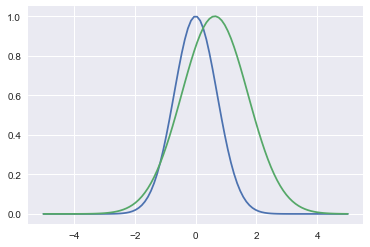

In [4]:
t = np.linspace(-5, 5, 100)
x = np.exp(-t**2)
y = np.exp(-(0.65 * t - 0.41)**2)
plt.plot(t,x)
plt.plot(t,y)

In [5]:
#x = np.array([0,2,4,2,0])
#y = np.array([0,1,2,3,4,5,4,3,2,1,0])
alst = np.linspace(0.1, 2, 50)

costold = []
costnew = []

for aval in alst:
    a_arr = np.array([0, aval])
    costold.append(total_cost(x, y, aval, 'sinc')[-1])
    costnew.append(total_cost_new(x, y, a_arr, 'sinc')[-1])

    boptions = np.linspace(0, 30, 100)
aoptions = np.linspace(0.1, 1, 100)
res = np.zeros((100, 100))
for idb, b in enumerate(boptions):
    for ida, a in enumerate(aoptions):
        valid_id, x_stretch, cost = total_cost_new(x,y, np.array([b, a]), 'linear')
        res[idb][ida] = cost
        #plt.plot(t[valid_id], x_stretch)
        #plt.plot(t, x)    

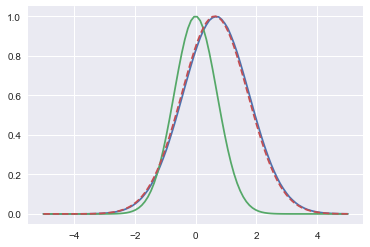

In [6]:
valid_id, x_stretch, cost = total_cost_new(x,y, np.array([13, 0.65]), 'linear')
plt.plot(t[valid_id], x_stretch)
plt.plot(t, x)
plt.plot(t, y, '--')

In [7]:
def make_all_pad(short_arr_file, long_arr_file, _t_points_short, _t_points_long, _n_neurons):
    '''Given the file names, return the reshaped_all_pad'''
    _short_psth = np.genfromtxt(short_arr_file, delimiter=',')
    _long_psth = np.genfromtxt(long_arr_file, delimiter=',')
    
    # Reshape the short and long raw data into tensors
    _reshaped_short_psth = np.reshape(_short_psth, (_n_neurons, _t_points_short, -1))
    _reshaped_long_psth = np.reshape(_long_psth, (_n_neurons, _t_points_long, -1))
    duration_short = _reshaped_short_psth.shape[2]
    duration_long = _reshaped_long_psth.shape[2]

    # Combine short and long trials into one tensor
    _reshaped_short_pad = np.lib.pad(_reshaped_short_psth, ((0,0), (0,0), 
                                                          (0, duration_long-duration_short)), 
                                    'constant', constant_values=(np.nan, np.nan))
    return np.concatenate((_reshaped_short_pad, _reshaped_long_psth), axis=1)


In [8]:
reshaped_all_pad_caudate = make_all_pad('./Raws/psth_short_all_neurons_nans_171102.csv', 
                               './Raws/psth_long_all_neurons_nans_171102.csv',
                               _t_points_short=7, _t_points_long=9, _n_neurons=105)
reshaped_all_pad_cortex = make_all_pad('./Raws/psth_short_XAcortexHand_171109.csv', 
                               './Raws/psth_long_XAcortexHand_171109.csv',
                               _t_points_short=6, _t_points_long=9, _n_neurons=284)

# Define palette used in plotting
palette_blue = sns.palettes.color_palette('Blues', 7)
palette_red = sns.palettes.color_palette('Reds', 9)

In [9]:
def get_stretch_neuron(all_neurons, neuron_id, stretches, intertype='sinc', normalize=True):
    '''Input: all_neurons: array of all neurons
    neuron_id: neuron of interest
    stretches: possible stretches to consider
    Returns the array of stretch for each condition'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] 
    if normalize:
        sref /= np.nanmedian(sref)
    
    min_stretch = []
    costs = []

    for i in range(all_neurons.shape[1]):
        s1 = all_neurons[neuron_id, i, :]
        s1 = s1[~np.isnan(s1)] 
        if normalize:
            s1 /= np.nanmedian(s1)
        cost = []
        for stretch in stretchlst:
            xs, cost_single = total_cost(s1, sref, stretch, intertype)
            cost.append(cost_single)
        costs.append(cost)
        min_stretch.append(stretchlst[np.argmin(cost)])
    return np.array(min_stretch)

def visualize_stretch(all_neurons, neuron_id, trial, stretch, intertype='sinc'):
    '''Given a neuronID and the stretch amount,
    plot the stretched trial'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmedian(sref)
    s1 = all_neurons[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmedian(s1)
    _, x = do_stretch(s1, stretch, intertype)
    plt.plot(sref, '--', label='Reference')
    plt.plot(s1, label='Before')
    plt.plot(x, label='After')
    plt.legend()
    

In [10]:
def get_stretch_neuron_new(all_neurons, neuron_id, boptions, aoptions, intertype='sinc'):
    '''Input: all_neurons: array of all neurons
    neuron_id: neuron of interest
    stretches: possible stretches to consider
    Returns the array of stretch for each condition'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    
    min_b_vals = []
    min_a_vals = []
    
    for i in range(all_neurons.shape[1]):
        print('Doing neuron #', i)
        s1 = all_neurons[neuron_id, i, :]
        s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
        bestcost = np.inf
        best_a = np.inf
        best_b = np.inf
        for ida, a in enumerate(aoptions):
            for idb, b in enumerate(boptions):
                _, _, cost = total_cost_new(s1, sref, np.array([b, a]), intertype)
                if cost < bestcost:
                    bestcost = cost
                    best_a = a
                    best_b = b
        
        min_a_vals.append(best_a)
        min_b_vals.append(best_b)
    return np.array([min_a_vals, min_b_vals])
    
    
def visualize_stretch_new(all_neurons, neuron_id, trial, a, intertype='sinc'):
    '''Given a neuronID and the stretch amount,
    plot the stretched trial'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    s1 = all_neurons[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    
    valid_id, x_stretch, cost = total_cost_new(s1, sref, a, 'linear')
    plt.plot(valid_id, x_stretch, label='After')
    plt.plot(s1, label='Before')
    plt.plot(sref, '--', label='Reference')
    plt.legend()
    

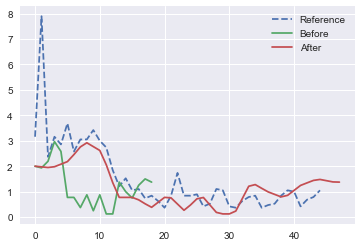

In [11]:
visualize_stretch(reshaped_all_pad_cortex, 0, 0, 0.39, 'linear')

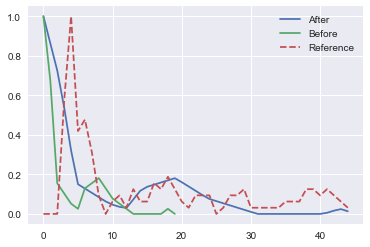

In [12]:
visualize_stretch_new(reshaped_all_pad_caudate, 10, 3, np.array([0, 0.42]), 'linear')

Stretch for single neuron

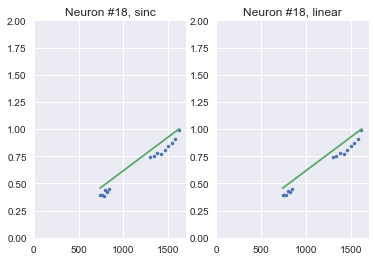

In [13]:
stretchlst = np.arange(0.1, 1.0, 0.01)
n_neuron = 18
min_stretch_sinc = get_stretch_neuron(reshaped_all_pad_cortex, n_neuron, stretchlst, 'sinc')
min_stretch_linear = get_stretch_neuron(reshaped_all_pad_cortex, n_neuron, stretchlst, 'linear')
times = np.array([740, 760, 780, 800, 820, 840, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])

plt.subplot('121')
plt.plot(times, min_stretch_sinc, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, min_stretch_linear, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', linear')


## Find stretch for all neurons

In [14]:
def find_stretch_all_neurons(psth_all, stretchlst, times):
    n_neurs = psth_all.shape[0]
    Min_stretch_sinc = np.zeros((n_neurs, len(times)))
    Min_stretch_linear = np.zeros((n_neurs, len(times)))
    for neuron_id in range(n_neurs):
        print('Aligning neuron #', neuron_id, ' of ', n_neurs)
        min_stretch_sinc = get_stretch_neuron(psth_all, neuron_id, stretchlst, 'sinc')
        min_stretch_linear = get_stretch_neuron(psth_all, neuron_id, stretchlst, 'linear')
        Min_stretch_sinc[neuron_id, :] = min_stretch_sinc
        Min_stretch_linear[neuron_id, :] = min_stretch_linear
        
    # Find the correlation coefficients
    corr_coefs_linear = np.corrcoef(times, Min_stretch_linear)[0,1:]
    corr_coefs_sinc = np.corrcoef(times, Min_stretch_sinc)[0,1:]
    
    return Min_stretch_linear, Min_stretch_sinc, corr_coefs_linear, corr_coefs_sinc

In [15]:
stretchlst = np.arange(0.1, 1.0, 0.01)
times_caudate = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
times_cortex = np.array([740, 760, 780, 800, 820, 840, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
stretch_lin_cortex, stretch_sinc_cortex, corr_lin_cortex, corr_sinc_cortex = \
        find_stretch_all_neurons(reshaped_all_pad_cortex, stretchlst, times_cortex)

stretch_lin_caudate, stretch_sinc_caudate, corr_lin_caudate, corr_sinc_caudate = \
        find_stretch_all_neurons(reshaped_all_pad_caudate, stretchlst, times_caudate)

Aligning neuron # 0  of  284
Aligning neuron # 1  of  284
Aligning neuron # 2  of  284
Aligning neuron # 3  of  284


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in subtract


Aligning neuron # 4  of  284
Aligning neuron # 5  of  284
Aligning neuron # 6  of  284
Aligning neuron # 7  of  284
Aligning neuron # 8  of  284
Aligning neuron # 9  of  284
Aligning neuron # 10  of  284
Aligning neuron # 11  of  284
Aligning neuron # 12  of  284
Aligning neuron # 13  of  284
Aligning neuron # 14  of  284
Aligning neuron # 15  of  284
Aligning neuron # 16  of  284
Aligning neuron # 17  of  284
Aligning neuron # 18  of  284
Aligning neuron # 19  of  284
Aligning neuron # 20  of  284
Aligning neuron # 21  of  284
Aligning neuron # 22  of  284
Aligning neuron # 23  of  284
Aligning neuron # 24  of  284
Aligning neuron # 25  of  284
Aligning neuron # 26  of  284
Aligning neuron # 27  of  284
Aligning neuron # 28  of  284
Aligning neuron # 29  of  284
Aligning neuron # 30  of  284
Aligning neuron # 31  of  284
Aligning neuron # 32  of  284
Aligning neuron # 33  of  284
Aligning neuron # 34  of  284
Aligning neuron # 35  of  284
Aligning neuron # 36  of  284
Aligning neuron 

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


Aligning neuron # 136  of  284
Aligning neuron # 137  of  284
Aligning neuron # 138  of  284
Aligning neuron # 139  of  284
Aligning neuron # 140  of  284
Aligning neuron # 141  of  284
Aligning neuron # 142  of  284
Aligning neuron # 143  of  284
Aligning neuron # 144  of  284
Aligning neuron # 145  of  284
Aligning neuron # 146  of  284
Aligning neuron # 147  of  284
Aligning neuron # 148  of  284
Aligning neuron # 149  of  284
Aligning neuron # 150  of  284
Aligning neuron # 151  of  284
Aligning neuron # 152  of  284
Aligning neuron # 153  of  284
Aligning neuron # 154  of  284
Aligning neuron # 155  of  284
Aligning neuron # 156  of  284
Aligning neuron # 157  of  284
Aligning neuron # 158  of  284
Aligning neuron # 159  of  284
Aligning neuron # 160  of  284
Aligning neuron # 161  of  284
Aligning neuron # 162  of  284
Aligning neuron # 163  of  284
Aligning neuron # 164  of  284
Aligning neuron # 165  of  284
Aligning neuron # 166  of  284
Aligning neuron # 167  of  284
Aligning

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Comparison caudate vs cortex

OSError: File exists!

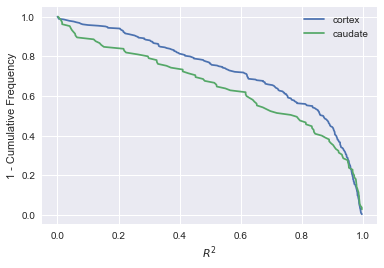

In [16]:
# Distribution of correlation coefs
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

x_cortex, y_cortex = ecdf(corr_lin_cortex**2)
x_caudate, y_caudate = ecdf(corr_lin_caudate**2)
plt.plot(x_cortex, 1 - y_cortex, label='cortex')
plt.plot(x_caudate, 1 - y_caudate, label='caudate')
plt.xlabel(r'$R^2$')
plt.ylabel('1 - Cumulative Frequency')
plt.legend()

save_safe('rev_cum_freq_R2vals_all_neurons_cortex_caudate.pdf')

In [ ]:
small = min_[corr_coefs >0.9,:]
corr_coefs_good = corr_coefs[corr_coefs >0.9]
idx = 11;
print(corr_coefs_good[idx])
plt.plot(times, small.T, 'bo', alpha=0.07);
plt.plot(times, small[idx,:], 'ro')
plt.plot(times, times/1620)
#plt.plot(times, np.mean(small, axis=0))
#plt.errorbar(times, np.mean(small, axis=0), yerr=np.std(small, axis=0), color='red')

Sinc and linear give similar results

In [ ]:
small = stretch_lin_cortex[corr_lin_cortex >0.95,:]
plt.plot(times, small.T, 'bo', alpha=0.07);
plt.plot(times, times/1620)
#plt.plot(times, np.mean(small, axis=0))
#plt.errorbar(times, np.mean(small, axis=0), yerr=np.std(small, axis=0), color='red')

In [ ]:
n_neuron = 0
times_zero = np.concatenate((times, [0]))

plt.subplot('121')
plt.plot(times_caudate, stretch_lin_caudate[n_neuron, :], '.')
#plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times_caudate, stretch_lin_caudate[n_neuron, :], '.')
#plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(n_neuron) + ', linear')

## Visualize neurons

In [ ]:
neuron_id = 4
sref = reshaped_all_pad_caudate[neuron_id, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmean(sref)

plt.figure(figsize=(10, 5)) 
plt.subplot('121')
for trial in range(15):
    s1 = reshaped_all_pad_caudate[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmean(s1)

    x_stretch, _ = total_cost(s1, sref, stretch_lin_caudate[neuron_id, trial], 'linear')
    
    if trial < 6:
        plt.plot(x_stretch, label=str(trial), color=palette_blue[trial])
    else:
        plt.plot(x_stretch, label=str(trial), color=palette_red[trial - 7])

plt.subplot('122')
plt.plot(times_caudate, stretch_lin_caudate[neuron_id, :], '.')
plt.xlim(0, 1700)
plt.ylim(0, 1.2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(neuron_id) + ', correlation = ' + str(corr_lin_caudate[neuron_id]))    

In [ ]:
plt.hist(corr_lin_caudate[~np.isnan(corr_lin_caudate)], bins=20, alpha=0.5, normed=True);
plt.hist(corr_lin_cortex[~np.isnan(corr_lin_cortex)], bins=20, alpha=0.5, normed=True);

### Fitting with two parameters, scale and shift 

In [ ]:
aopts = np.arange(0.1, 1.0, 0.01)
bopts = np.arange(-5, 5)
n_neuron = 0
min_stretch_sinc = get_stretch_neuron_new(reshaped_all_pad, n_neuron, 
                                          boptions, aoptions, 'sinc')
#min_stretch_linear = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'linear')
times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])

In [ ]:
visualize_stretch_new(reshaped_all_pad, 0, 1, np.array([3.63, 0.309]), 'linear')

In [ ]:
s1 = reshaped_all_pad[0, 0, :]
sref = reshaped_all_pad[0, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmax(sref)
s1 = s1[~np.isnan(s1)] / np.nanmax(s1)


plt.plot(s1)
plt.plot(sref)

In [ ]:
plt.subplot('121')
plt.plot(times, min_stretch_sinc, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, min_stretch_linear, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', linear')

In [ ]:
ntimes = 15
neuron = 23
sref = reshaped_all_pad[neuron, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmax(sref)
stretchlst = np.arange(0.1, 1.0, 0.001)

min_stretch = []
for i in range(16):
    s1 = reshaped_all_pad[neuron, i, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    cost = []
    for a in stretchlst:
        xs, cost_single = total_cost(s1, sref, a)
        cost.append(cost_single)
    min_stretch.append(stretchlst[np.argmin(cost)])
    #print(stretchlst[np.argmin(cost)])

times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
plt.plot(times, np.array(min_stretch), '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)

## Load saved data in warp files

In [41]:
stretch_twpca_caudate = np.zeros_like(stretch_lin_caudate)

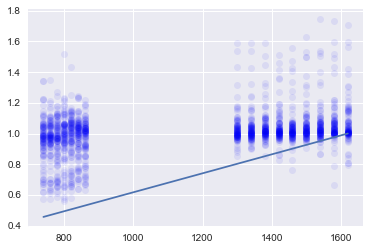

In [55]:
plt.plot(times_caudate, 1/stretch_twpca_caudate.T, 'bo', alpha=0.07);
plt.plot(times_caudate, times_caudate / max(times_caudate))

In [54]:
for i in range(105):
    print('Working on neuron %d' % i)
    filename = './Processed_neurons/XACaudate/neuron%d_init_shift_warp_affine_warp.csv' % i
    try:
        warp = np.loadtxt(filename, delimiter=',')
    except FileNotFoundError:
        pass
    stretch_twpca_caudate[i,:] = (warp[:,-1] - warp[:,0]) / (warp.shape[1] - 1)

Working on neuron 0
Working on neuron 1
Working on neuron 2
Working on neuron 3
Working on neuron 4
Working on neuron 5
Working on neuron 6
Working on neuron 7
Working on neuron 8
Working on neuron 9
Working on neuron 10
Working on neuron 11
Working on neuron 12
Working on neuron 13
Working on neuron 14
Working on neuron 15
Working on neuron 16
Working on neuron 17
Working on neuron 18
Working on neuron 19
Working on neuron 20
Working on neuron 21
Working on neuron 22
Working on neuron 23
Working on neuron 24
Working on neuron 25
Working on neuron 26
Working on neuron 27
Working on neuron 28
Working on neuron 29
Working on neuron 30
Working on neuron 31
Working on neuron 32
Working on neuron 33
Working on neuron 34
Working on neuron 35
Working on neuron 36
Working on neuron 37
Working on neuron 38
Working on neuron 39
Working on neuron 40
Working on neuron 41
Working on neuron 42
Working on neuron 43
Working on neuron 44
Working on neuron 45
Working on neuron 46
Working on neuron 47
Wo

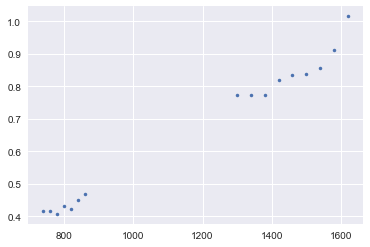

In [38]:
plt.plot(times_caudate, 1/stretches, '.')